# PXD012477
## Proteomic analyses of urine for healty ageing study

[PRIDE link](https://www.ebi.ac.uk/pride/archive/projects/PXD012477)

[Article link](https://link.springer.com/article/10.1007/s11357-020-00269-y)

In [77]:
#Import libraries
os.chdir("/home/robbe/ionbot/")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import numpy as np
import os
from pathlib import Path
from pyteomics import mass as pymass
import OxiAnalysis as OA
import importlib
importlib.reload(OA)

<module 'OxiAnalysis' from '/home/robbe/ionbot/OxiAnalysis.py'>

In [78]:
first = pd.read_csv('/home/robbe/ionbot/mastersets/PXD012477_first.csv')
first.head()

,Unnamed: 0,ionbot_match_id,spectrum_title,scan,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,...,Organism,Cell line,Oxidant treatment,Oxidant dose (µM),Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting
0,0,0_4121_1,controllerType=0 controllerNumber=1 scan=10001,10001,1DLC0080815QE_RRAG_001_rep1,879.42991,8794.3378,2170.70418,2,IDGSVDFK,...,Human,Urine,Healthy Ageing,0,None,0,0,0,NaN,First
1,1,0_4122_1,controllerType=0 controllerNumber=1 scan=10002,10002,1DLC0080815QE_RRAG_001_rep1,1177.60447,11766.0599,2170.83888,2,EITAIAPSTMK,...,Human,Urine,Healthy Ageing,0,None,0,0,0,NaN,First
2,2,0_4123_2,controllerType=0 controllerNumber=1 scan=10003,10003,1DLC0080815QE_RRAG_001_rep1,986.50168,9855.0146,2170.97352,2,IPACIAGER,...,Human,Urine,Healthy Ageing,0,None,0,0,0,NaN,First
3,3,0_4126_2,controllerType=0 controllerNumber=1 scan=10007,10007,1DLC0080815QE_RRAG_001_rep1,844.44016,8444.4428,2171.58480,2,FPETVPR,...,Human,Urine,Healthy Ageing,0,None,0,0,0,NaN,First
4,4,0_4128_1,controllerType=0 controllerNumber=1 scan=10011,10011,1DLC0080815QE_RRAG_001_rep1,1791.87363,18058.9815,2172.40680,2,VPEPCPSTVTPAPAQQK,...,Human,Urine,Healthy Ageing,0,None,0,0,0,NaN,First


In [79]:
del first["Unnamed: 0"]
del first["spectrum_title"]
del first["scan"]
first['modifications'] = first['modifications'].fillna("None")
first['Oxidant treatment'] = first['Oxidant treatment'].fillna("None")
first['Secondary treatment'] = first['Secondary treatment'].fillna("None")
first['Length of Secondary treatment (mins)'] = first['Length of Secondary treatment (mins)'].fillna(0)
first['Length of oxidant treatment (mins)'] = first['Length of oxidant treatment (mins)'].replace('0', 0)

In [80]:
print("The amount of PSMs in this project dataset is: ", first.shape[0])
print("The amount of raw files that make up the master dataset is: ", len(first["spectrum_file"].unique()))

The amount of PSMs in this project dataset is:  5737728
The amount of raw files that make up the master dataset is:  489


In [81]:
first['Peptidoform_name'] = first.apply(lambda row: OA.peptidoform_name(row), axis=1)
first['Position'] = first['modifications'].apply(OA.get_positions)
first['Modification'] = first['modifications'].apply(OA.get_modification)
first['Oxidatively_modified'] = first['modifications'].apply(OA.oxidatively_modified)

## Overview of the treatments in this project

In [82]:
first.groupby(["Oxidant treatment", "Oxidant dose (µM)", "Length of oxidant treatment (mins)", "Secondary treatment", "Secondary treatment dose (µM)", 'Length of Secondary treatment (mins)'])["ionbot_match_id"].count().to_frame().reset_index()

,Oxidant treatment,Oxidant dose (µM),Length of oxidant treatment (mins),Secondary treatment,Secondary treatment dose (µM),Length of Secondary treatment (mins),ionbot_match_id
0,Healthy Ageing,0,0,None,0,0,2706289
1,Non-Healthy Ageing,0,0,None,0,0,3031439


In [83]:
H = first.loc[lambda first: first["Oxidant treatment"] == "Healthy Ageing"]
NH = first.loc[lambda first: first["Oxidant treatment"] == "Non-Healthy Ageing"]

In [84]:
print("There are this many replicates of Healthy Ageing treatment: {}".format(H["spectrum_file"].nunique()))
print("There are this many replicates of Non-Healthy Ageing treatment: {}".format(NH["spectrum_file"].nunique()))

There are this many replicates of Healthy Ageing treatment: 234
There are this many replicates of Non-Healthy Ageing treatment: 255


In [85]:
Hrep = OA.replicate_filter(H, 117)
NHrep = OA.replicate_filter(NH, 128)

### Oxidatively modified PSMs

In [86]:
print("The ratio of PSMs that contain an oxidative modification in the Healthy Ageing treatment subset: {}".format((Hrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the Non-Healthy Ageing treatment subset: {}".format((NHrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the Healthy Ageing treatment subset: 7.934462589859209 %
The ratio of PSMs that contain an oxidative modification in the Non-Healthy Ageing treatment subset: 9.153490894450684 %


In [87]:
mrHrep = OA.modratios(Hrep)
mrNHrep = OA.modratios(NHrep)

In [88]:
modr = pd.merge(mrNHrep, mrHrep, on="Modification", suffixes=('_NH', '_H'))
modr["Difference"] = modr["Ratios_NH"] - modr["Ratios_H"]
modr = modr.drop(modr[(modr["Ratios_NH"] == 0) | (modr["Ratios_H"] == 0)].index)
modr

,Modification,Ratios_NH,Ratios_H,Difference
0,[35]Oxidation[T],0.001547,0.000773,7.734775e-04
1,[35]Oxidation[E],0.002202,0.001181,1.021114e-03
2,[35]Oxidation[S],0.000726,0.000230,4.956490e-04
3,[35]Oxidation[Q],0.000475,0.000392,8.291610e-05
5,[35]Oxidation[I],0.003977,0.002115,1.861195e-03
...,...,...,...,...
119,[1918]Carbonyl[A],0.000005,0.000005,-2.344537e-07
120,[1918]Carbonyl[V],0.000025,0.000011,1.394830e-05
121,[1922]Pro->HAVA[P],0.000419,0.000322,9.744242e-05
124,[1925]Delta:O(4)[W],0.001191,0.001527,-3.358913e-04


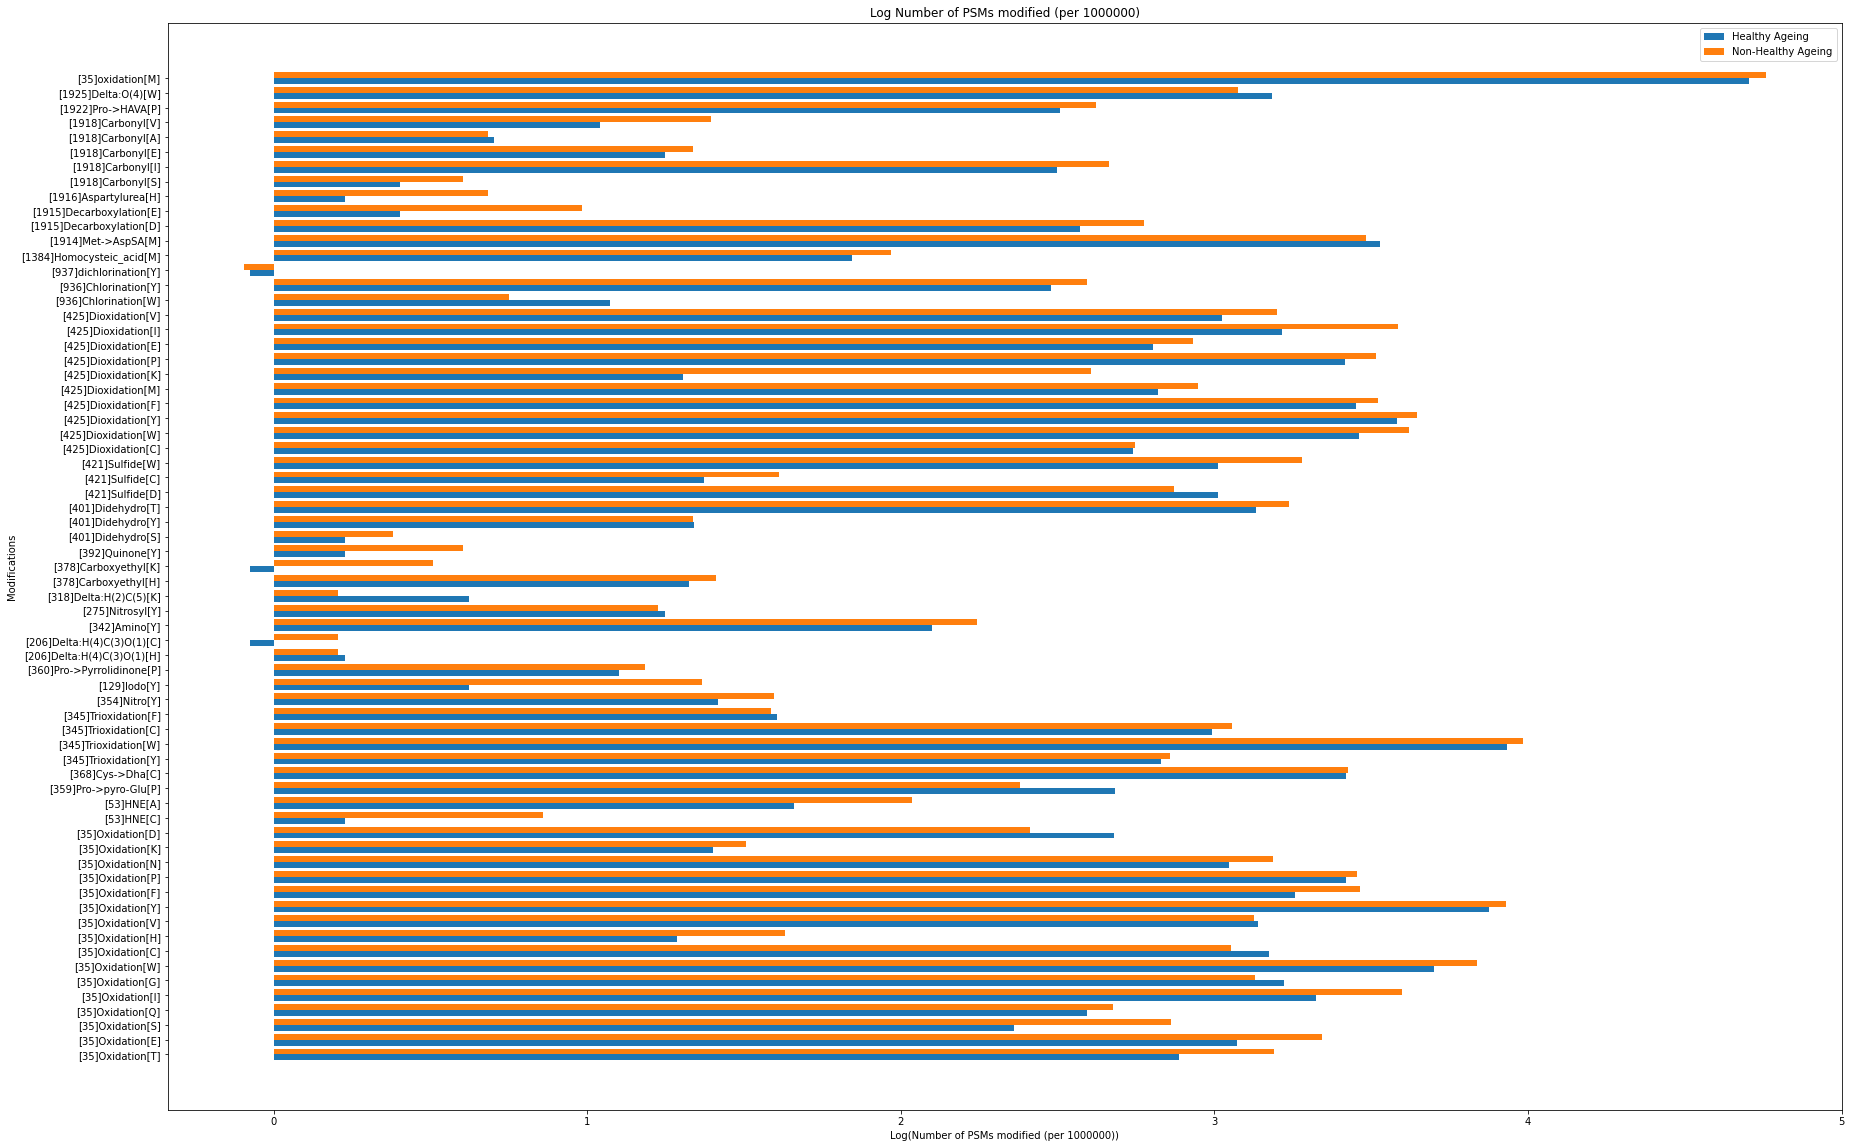

In [89]:
y = modr["Modification"]
xnone = np.log10(modr['Ratios_H']*1000000)
xH = np.log10(modr['Ratios_NH']*1000000)
y_axis = np.arange(len(y))

plt.figure(figsize=(30,20))
plt.barh(y_axis - 0.2, xnone, 0.4, label = 'Healthy Ageing')
plt.barh(y_axis + 0.2, xH, 0.4, label = 'Non-Healthy Ageing')

plt.yticks(y_axis, y)
plt.ylabel("Modifications")
plt.xlabel("Log(Number of PSMs modified (per 1000000))")
plt.title("Log Number of PSMs modified (per 1000000)")

plt.legend()
plt.show()

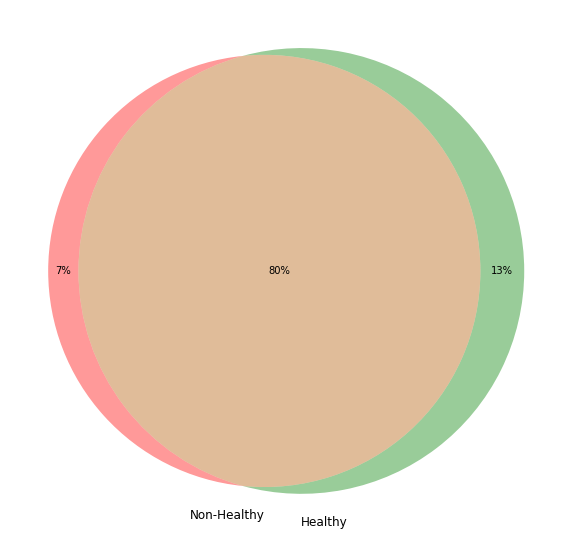

In [90]:
OA.condition_venn([NHrep,Hrep], ["Non-Healthy", "Healthy"])

In [91]:
difflist, pf_only_treatment = OA.comparelist(NHrep, Hrep)
pf_only_treatment.head()

,ionbot_match_id,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,matched_peptide,modifications,modifications_delta,...,Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting,Peptidoform_name,Position,Modification,Oxidatively_modified
22364,0_4091_1,1DLC0080815QE_RRAG_002_rep1,1124.56150,11245.6479,2192.88918,2,KASYIDCIR,KASYIDCIR,7|[4]carbamidomethyl[C],7|57.0215,...,None,0,0,0,NaN,First,KASYIDC[4]carbamidomethylIR,7,[4]carbamidomethyl[C],False
22425,0_4213_2,1DLC0080815QE_RRAG_002_rep1,1124.56077,11245.6479,2214.10302,2,KASYIDCIR,KASYIDCIR,7|[4]carbamidomethyl[C],7|57.0215,...,None,0,0,0,NaN,First,KASYIDC[4]carbamidomethylIR,7,[4]carbamidomethyl[C],False
22530,0_4466_1,1DLC0080815QE_RRAG_002_rep1,1159.48191,11594.8555,2269.33242,2,SDVMYTDWK,SDVMYTDWK,4|[35]oxidation[M],4|15.9949,...,None,0,0,0,NaN,First,SDVM[35]oxidationYTDWK,4,[35]oxidation[M],True
22570,0_4562_1,1DLC0080815QE_RRAG_002_rep1,1159.48130,11594.8555,2290.76466,2,SDVMYTDWK,SDVMYTDWK,4|[35]oxidation[M],4|15.9949,...,None,0,0,0,NaN,First,SDVM[35]oxidationYTDWK,4,[35]oxidation[M],True
22578,0_4579_1,1DLC0080815QE_RRAG_002_rep1,1995.90633,19959.2208,2293.89780,3,NECFIQHKDDNPNIPR,NECFIQHKDDNPNIPR,3|[4]carbamidomethyl[C],3|57.0215,...,None,0,0,0,NaN,First,NEC[4]carbamidomethylFIQHKDDNPNIPR,3,[4]carbamidomethyl[C],False


In [92]:
onlytreatment = OA.modcounts(pf_only_treatment)
onlytreatment = onlytreatment.sort_values("Counts", ascending=False).drop(onlytreatment[onlytreatment["Counts"] == 0].index, axis=0)
onlytreatment

,Modification,Counts
129,[35]oxidation[M],6497
8,[35]Oxidation[W],2982
32,[345]Trioxidation[W],2035
85,[425]Dioxidation[I],1925
15,[35]Oxidation[F],1303
77,[425]Dioxidation[W],1128
5,[35]Oxidation[I],1125
74,[421]Sulfide[W],1101
1,[35]Oxidation[E],856
0,[35]Oxidation[T],807


In [93]:
RPMH = OA.relative_PSM_modification(Hrep)
RPMNH = OA.relative_PSM_modification(NHrep)

In [94]:
RPM = pd.merge(RPMH,RPMNH, on="Amino acid", suffixes=('_H', '_NH'))
RPM

,Amino acid,Relative level of PSMs containing unmodified residue_H,Relative level of PSMs containing unmodified residue_NH
0,A,0.997788,0.998003
1,R,0.999596,0.999512
2,N,0.970901,0.974015
3,D,0.994760,0.995557
4,C,0.032009,0.030566
5,Q,0.994747,0.994759
6,E,0.994192,0.992131
7,G,0.998093,0.998627
8,H,0.985067,0.979621
9,I,0.997205,0.994451


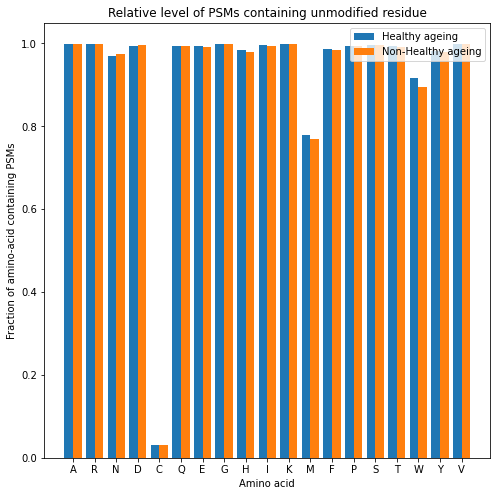

In [95]:
x = RPM["Amino acid"]
xnone = RPM["Relative level of PSMs containing unmodified residue_H"]
xH = RPM['Relative level of PSMs containing unmodified residue_NH']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xnone, 0.4, label = 'Healthy ageing')
plt.bar(x_axis + 0.2, xH, 0.4, label = 'Non-Healthy ageing')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (8,8)
plt.legend()
plt.show()

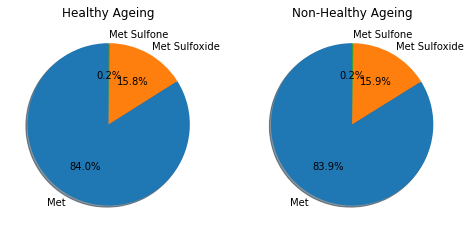

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2)
OA.methionine_overview(Hrep, ax1)
OA.methionine_overview(NHrep, ax2)
plt.title("Methionine containing peptides")
ax1.set_title("Healthy Ageing")
ax2.set_title("Non-Healthy Ageing")
plt.show()

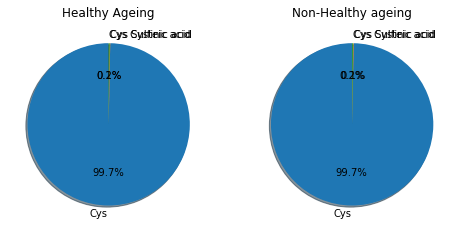

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2)
OA.cysteine_overview(Hrep, ax1)
OA.cysteine_overview(NHrep, ax2)
plt.title("cysteine containing peptides")
ax1.set_title("Healthy Ageing")
ax2.set_title("Non-Healthy ageing")
plt.show()